In [127]:
using Pkg
Pkg.activate("/home/fedflorio/master_thesis/")

  Activating project at `~/master_thesis`


In [128]:
using MatrixProductBP, MatrixProductBP.Models
using Graphs, IndexedGraphs, Statistics, Random, LinearAlgebra, PyPlot, DelimitedFiles, JLD2
using TensorTrains: summary_compact
using SparseArrays

include("/home/fedflorio/master_thesis/Utilities/roc.jl")
include("/home/fedflorio/master_thesis/Utilities/correlations.jl");

In [129]:
A = readdlm("/home/fedflorio/master_thesis/MatrixProductBP.jl/notebooks/karate.txt", Bool)
g = IndexedGraph(A)

nsnaps = 100
separation = 64
T = nsnaps * separation
N = nv(g)
seed = 4

λ_unif = 0.02
ρ_unif = 0.02
λ = zeros(N,N)
for i in CartesianIndices(λ)
    if !iszero(g.A[i])
        # λ[i] = rand()
        λ[i] = λ_unif
    end
end
λ = sparse(λ)
# ρ = rand(N)
ρ = fill(ρ_unif,N)
γ = [i==1 ? 1.0 : 0.0 for i in 1:N]

sis = SIS_heterogeneous(λ, ρ, T; γ)
bp_obs = mpbp(sis)

obs_times = collect(range(separation, step=separation, length=nsnaps))
nobs = floor(Int, N * length(obs_times) * 1.0)
obs_fraction = nobs / N
rng = MersenneTwister(seed)
X, observed = draw_node_observations!(bp_obs, nobs, times = obs_times .+ 1, softinf=Inf; rng)
X

34×6401 Matrix{Int64}:
 2  2  2  2  2  2  2  2  2  2  2  2  2  …  2  2  2  2  2  2  2  2  2  2  2  2
 1  1  1  1  1  1  1  1  1  1  1  1  1     2  2  2  2  2  2  2  2  2  2  2  2
 1  1  1  1  1  1  1  1  1  1  1  1  1     2  2  2  2  2  2  2  2  2  2  2  2
 1  1  1  1  1  1  1  1  1  1  1  1  1     2  2  2  2  2  2  2  2  2  2  2  2
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  2  2  2  2  2  2  …  2  2  2  2  2  2  2  2  2  2  2  2
 1  1  1  1  1  1  1  1  1  1  1  1  1     2  2  2  2  2  2  2  2  2  2  2  2
 1  1  1  1  1  1  1  1  1  1  1  1  2     2  2  2  2  2  2  2  2  2  2  2  2
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  2  2  2  2  2  2  2  2  2  2  2
 1  1  1  1  1  1  1  1  1  1  1  1  1     2  2  2  2  2  2  2  2  2  2  2  2
 1  1  1  1  1  1  1  2  2  2  2  2  2  …  2  2  2  2  2  2  2  2  2  2  2  2
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1   

In [130]:
neigs = load("/home/fedflorio/master_thesis/MatrixProductBP.jl/notebooks/sis_inference_data/karate_add_neigs.jld2")["neigs"]

corr = correlations_traj(X[:,separation+1:separation:end])
for (i,c) in enumerate(corr)
    corr[i] = vcat(c[1:i-1],0.0,c[i:end])
end
λcorr = [corr[i][neigs[i][:]] for i in eachindex(neigs)];

auc = 0.6303418803418803


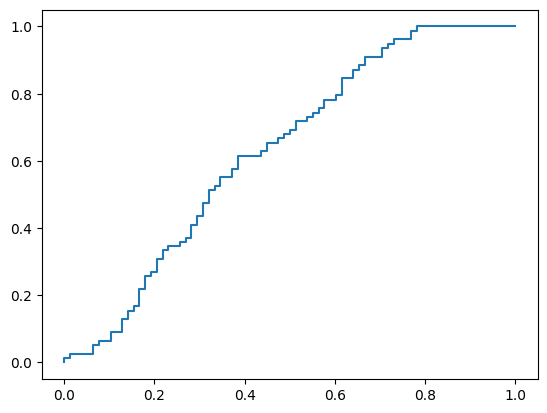

In [131]:
xplot, yplot, area = roccurve_incomplete(deepcopy(λcorr), λ, neigs)
close("all")
plot(xplot,yplot)
println("auc = $area")